# Propuesta de Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: **Geraldine Coli Acevedo**, **Carlos Olguín**, **René Saavedra Vargas**.  

## 1. Introducción

El siguiente cuaderno presenta una propuesta de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realiza un análisis exploratorio de datos sobre un conjunto de datos de ratings de Amazon (enfocado en Videojuegos). El conjunto de datos se obtiene a partir de [Amazon Review Data (2023)](https://amazon-reviews-2023.github.io) de McAuley Lab. En particular se utiliza el conjunto **Video Games (Review, Metadata)** para obtener los ratings de los videojuegos y su información asociada.

Para ejecutar este cuaderno, es necesario descargar los archivos y descomprimirlos en la carpeta `data/`.

## 2. Pasos preliminares

### 2.1. Variables

In [199]:
TEST_SIZE = 0.1
DATASET_SIZE = 0.01
RANDOM_STATE = 42
MIN_REVIEW_COUNT = 5

### 2.2. Instalación de dependencias


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable


### 2.3. Cargar datos

In [3]:
metadata_path   = os.path.join('newproject', 'meta_Video_Games.jsonl')
video_games_path = os.path.join('newproject', 'Video_Games.jsonl')

metadata_df    = pd.read_json(metadata_path, lines=True)
video_games_df = pd.read_json(video_games_path, lines=True)

print(metadata_df.shape, metadata_df.columns)
print(video_games_df.shape, video_games_df.columns)

(137269, 16) Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')
(4624615, 10) Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


         rating                                             title  \
2369241       5  Everything you need for the nintendo switch oled   

                                                      text images        asin  \
2369241  A complete set of things you must have to prot...     []  B09FJKC55L   

        parent_asin                       user_id               timestamp  \
2369241  B0C69F9BRQ  AGKOSYSLXQFZMVHB37N4ICFPALTA 2021-12-11 01:51:20.958   

         helpful_vote  verified_purchase  
2369241             0               True  


In [69]:
filtered_df = video_games_df[
    video_games_df.groupby('user_id')['user_id'].transform('count') > 1
]

df = filtered_df.sample(frac=TEST_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)

print(df.shape, df.columns)

(262686, 10) Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [74]:
# search in metadata_df if there are repeated title
repeated_titles = metadata_df[metadata_df.duplicated(subset=['title'], keep=False)]
print(repeated_titles.shape, repeated_titles.columns)

(11326, 17) Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author',
       'text_features'],
      dtype='object')


### 2.4. Preprocesar datos

In [201]:
filtered_df = video_games_df[
    video_games_df.groupby('user_id')['user_id'].transform('count') > MIN_REVIEW_COUNT
].copy()

print(video_games_df.shape, filtered_df.shape)

filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
filtered_df = filtered_df.sort_values('timestamp').reset_index(drop=True)

(4624615, 10) (848344, 10)


In [202]:
train_parts = []
test_parts  = []

for user_id, group in filtered_df.groupby('user_id'):
    test_parts.append(group.iloc[[-1]])
    train_parts.append(group.iloc[:-1])


train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)

print("After split →")
print("  train_df.shape:", train_df.shape)
print("  test_df.shape: ", test_df.shape)



After split →
  train_df.shape: (767039, 10)
  test_df.shape:  (81305, 10)


In [71]:
print(train_df.shape, test_df.shape)

(51530, 10) (211156, 10)


In [203]:
def df_stats(interactions_df, metadata_df):
    # ————— Estadísticas de interacciones —————
    n_users = interactions_df['user_id'].nunique()
    n_items = interactions_df['parent_asin'].nunique()
    total_ratings = len(interactions_df)
    avg_rpu = round(total_ratings / n_users, 1) if n_users > 0 else 0.0
    avg_rpi = round(total_ratings / n_items, 1) if n_items > 0 else 0.0
    avg_rating = round(interactions_df['rating'].mean(), 1) if total_ratings > 0 else 0.0
    std_rating = round(interactions_df['rating'].std(), 1) if total_ratings > 1 else 0.0

    if total_ratings > 0:
        max_by_user = int(interactions_df.groupby('user_id').size().max())
        max_by_item = int(interactions_df.groupby('asin').size().max())
    else:
        max_by_user = 0
        max_by_item = 0

    # ————— Estadísticas de descripciones —————
    # Obtener los parent_asin que están en las interacciones
    relevant_asins = interactions_df['parent_asin'].unique()
    filtered_metadata = metadata_df[metadata_df['parent_asin'].isin(relevant_asins)].copy()

    # Normalizar las descripciones
    def normalize_desc(x):
        if isinstance(x, list):
            return ' '.join([str(fragment) for fragment in x if fragment])
        elif isinstance(x, str):
            return x
        else:
            return ''

    desc_series = filtered_metadata['description'].apply(normalize_desc)
    desc_word_counts = desc_series.apply(lambda txt: len(txt.split()) if txt.strip() else 0)

    n_items_with_desc = int((desc_word_counts > 0).sum())
    n_items_without_desc = int((desc_word_counts == 0).sum())

    if n_items_with_desc > 0:
        min_len = int(desc_word_counts[desc_word_counts > 0].min())
        max_len = int(desc_word_counts.max())
        mean_len = round(desc_word_counts[desc_word_counts > 0].mean(), 1)
        std_len = round(desc_word_counts[desc_word_counts > 0].std(), 1)
    else:
        min_len = 0
        max_len = 0
        mean_len = 0.0
        std_len = 0.0

    return {
        # — Estadísticas de interacciones —
        'Número de usuarios'                  : n_users,
        'Número de ítems'                    : n_items,
        'Cantidad total de ratings'          : total_ratings,
        'Promedio de ratings por usuario'     : avg_rpu,
        'Promedio de ratings por ítem'       : avg_rpi,
        'Rating promedio'                    : avg_rating,
        'Desviación estándar del rating'     : std_rating,
        'Máximo de ratings por usuario'      : max_by_user,
        'Máximo de ratings por ítem'         : max_by_item,

        # — Estadísticas de descripciones —
        'Número de ítems sin descripción'    : n_items_without_desc,
        'Número de ítems con descripción'    : n_items_with_desc,
        'Longitud mínima de descripción'     : min_len,
        'Longitud máxima de descripción'     : max_len,
        'Longitud promedio de descripción'   : mean_len,
        'Desviación estándar longitud descr' : std_len,
    }


In [204]:
stats_train = df_stats(train_df, metadata_df)
stats_test = df_stats(test_df, metadata_df)

table = PrettyTable()
table.field_names = ["Estadística", "Train", "Test"]
for key in stats_train.keys():
    table.add_row([key, stats_train[key], stats_test[key]])

print(table)


+------------------------------------+--------+-------+
|            Estadística             | Train  |  Test |
+------------------------------------+--------+-------+
|         Número de usuarios         | 81305  | 81305 |
|          Número de ítems           | 72924  | 25975 |
|     Cantidad total de ratings      | 767039 | 81305 |
|  Promedio de ratings por usuario   |  9.4   |  1.0  |
|    Promedio de ratings por ítem    |  10.5  |  3.1  |
|          Rating promedio           |  4.3   |  4.2  |
|   Desviación estándar del rating   |  1.2   |  1.3  |
|   Máximo de ratings por usuario    |  663   |   1   |
|     Máximo de ratings por ítem     |  2244  |  311  |
|  Número de ítems sin descripción   | 23540  |  8882 |
|  Número de ítems con descripción   | 49384  | 17093 |
|   Longitud mínima de descripción   |   1    |   1   |
|   Longitud máxima de descripción   | 15942  | 15942 |
|  Longitud promedio de descripción  | 170.5  | 197.1 |
| Desviación estándar longitud descr | 270.0  | 

Realizamos gráficos para analizar los datos.

#### 2.5. Analisis de datos

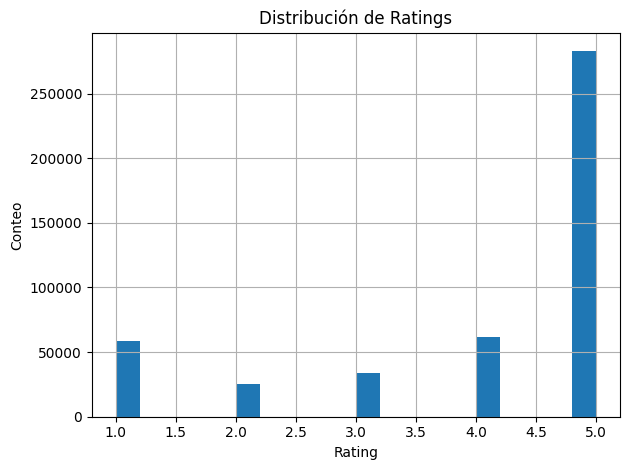

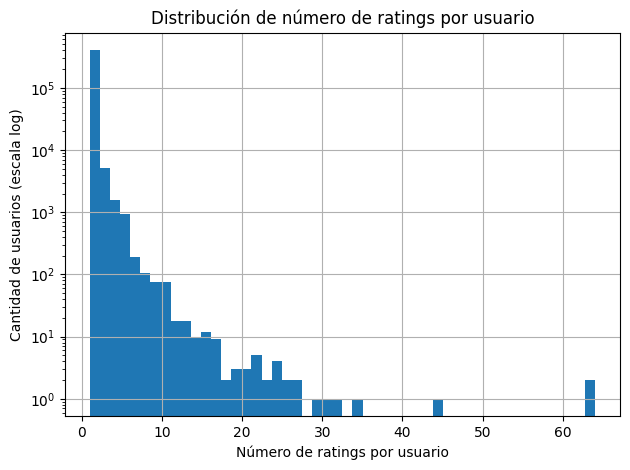

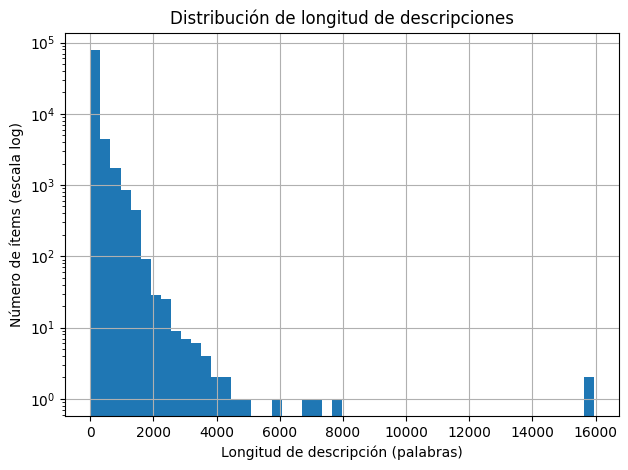

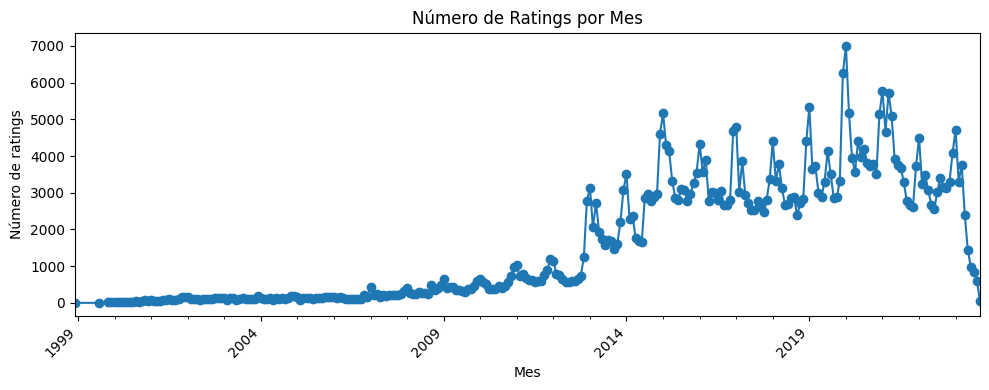

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Histograma de distribución de ratings
plt.figure()
df['rating'].hist(bins=20)
plt.xlabel('Rating')
plt.ylabel('Conteo')
plt.title('Distribución de Ratings')
plt.tight_layout()

# 2. Histograma de número de ratings por usuario (escala logarítmica)
user_counts = df.groupby('user_id').size()
plt.figure()
user_counts.hist(bins=50, log=True)
plt.xlabel('Número de ratings por usuario')
plt.ylabel('Cantidad de usuarios (escala log)')
plt.title('Distribución de número de ratings por usuario')
plt.tight_layout()

# 3. Histograma de longitud de descripciones (solo ítems con descripción)
def normalize_desc(x):
    if isinstance(x, list):
        return ' '.join([str(fragment) for fragment in x if fragment])
    elif isinstance(x, str):
        return x
    else:
        return ''

desc = metadata_df['description'].apply(normalize_desc).fillna('')
desc_lens = desc.apply(lambda t: len(t.split()) if t.strip() else 0)
plt.figure()
desc_lens[desc_lens > 0].hist(bins=50, log=True)
plt.xlabel('Longitud de descripción (palabras)')
plt.ylabel('Número de ítems (escala log)')
plt.title('Distribución de longitud de descripciones')
plt.tight_layout()

# 4. Serie de tiempo: número de ratings por mes
df['year_month'] = df['timestamp'].dt.to_period('M')

monthly_counts = df.groupby('year_month').size().sort_index()
plt.figure(figsize=(10, 4))
monthly_counts.plot(marker='o', linestyle='-')
plt.xlabel('Mes')
plt.ylabel('Número de ratings')
plt.title('Número de Ratings por Mes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



## 3. Modelos de prueba

#### 3.1. Modelos simples

In [47]:
def asin_to_title(asin: str) -> str:
    """
    Dada un ASIN, devuelve el título del videojuego.
    """
    if asin in metadata_df['parent_asin'].values:
        return metadata_df.loc[metadata_df['parent_asin'] == asin, 'title'].values[0]
    else:
        return "Título no encontrado"
    
def print_recommendations(recommendations: list):
    """
    Imprime las recomendaciones con sus títulos.
    """
    print("Recomendaciones:")
    for asin in recommendations:
        title = asin_to_title(asin)
        print(f"- {title} (ASIN: {asin})")
    

Realizamos pruebas con diferentes modelos simples de referencia. Utilizamos una clase RecomendadorBase que se utiliza para crear los otros recomendadores.

In [40]:
from surprise import Dataset, Reader, KNNBasic, SVD

class RecomendadorBase:
    """
    Clase base para todos los recomendadores.
    Formato a utilizar: userId, itemId, rating
    """
    def fit(self, df: pd.DataFrame):
        raise NotImplementedError

    def recommend(self, user_id, n_items=10):
        raise NotImplementedError

Recomendadores base, Random y Most Popular. Estos recomendadores no utilizan información de los usuarios ni de los ítems, sino que se basan en estrategias simples para generar recomendaciones.

In [ ]:
class RecomendadorRandom(RecomendadorBase):
    """
    Recomendador aleatorio.
    """
    import numpy as np
    def fit(self, df: pd.DataFrame):
        self.df = df['parent_asin'].unique().tolist()

    def recommend(self, user_id, n_items=10):
        recs = np.random.choice(self.df, size=n_items, replace=False)
        return recs.tolist()
    
class RecomendadorPopular(RecomendadorBase):
    """
    Recomendador basado en popularidad.
    """
    def fit(self, df: pd.DataFrame):
        train_pos = df[df['rating'] >= 4]

        pop_counts = (
            train_pos
            .groupby('asin')
            .size()
            .reset_index(name='pos_count')
            .sort_values('pos_count', ascending=False)
        )
        
        self.most_popular_list = pop_counts['parent_asin'].tolist()

    def recommend(self, user_id, n_items=10):
        return self.most_popular_list[:n_items]


#### 3.2. Modelo basado en contenido

In [134]:
from scipy.sparse import vstack

def user_profile(user_id):
    # Ítems positivos en train (rating >= 4)
    uid_train_pos = df[
        (df['user_id'] == user_id) & (df['rating'] >= 4)
    ]['asin'].tolist()
    vectors = []
    
    for a in uid_train_pos:
        if a in item_to_idx:
            vectors.append(item_tfidf[item_to_idx[a]])
    if not vectors:
        return None
    return vstack(vectors).mean(axis=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import vstack
import numpy as np

class RecomendadorContent(RecomendadorBase):
    """
    Recomendador basado en contenido (TF-IDF + cosine).
    """
    def fit(self, df: pd.DataFrame):
        self.df = df

        # Utiliza la review del usuario como texto para el TF-IDF
        df['text_features'] = (
            df['title'].fillna('') + ' ' +
            df['text'].fillna('')
        )

        self.tfidf = TfidfVectorizer(max_features=5000)
        self.item_tfidf = self.tfidf.fit_transform(df['text_features'])

        self.item_to_idx = {asin: idx for idx, asin in enumerate(df['parent_asin'])}
        self.asin_list = list(df['parent_asin'])

    def recommend(self, user_id, n_items=10):
        # 1) Obtenemos los ítems que el usuario ha valorado >= 4 en el DF de entrenamiento
        
        user_hist = self.df[(self.df['user_id'] == user_id) & (self.df['rating'] >= 4)]['parent_asin'].tolist()
        
        if not user_hist:
            # Si no hay historial positivo, caemos al recomendador de popularidad (Fallback)
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 2) Convertir el historial a índices TF-IDF
        idx_list = [self.item_to_idx[asin] for asin in user_hist if asin in self.item_to_idx]
        if not idx_list:
            # Si ninguno de los ASIN del historial está en metadata_df
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 3) Calcular vector de perfil del usuario (media de sus vectores TF-IDF)
        user_vec = vstack([self.item_tfidf[i] for i in idx_list]).mean(axis=0)
        user_vec = np.asarray(user_vec) # Arregla error en python 3.11

        sims = linear_kernel(user_vec, self.item_tfidf).flatten()  # ya es np.ndarray

        # 5) Ordenar de mayor a menor similitud y filtrar los ya vistos
        top_indices = np.argsort(sims)[::-1]
        recs = []
        seen = set(self.df[self.df['user_id'] == user_id]['parent_asin'].tolist())
        for idx in top_indices:
            cand_asin = self.asin_list[idx]
            if cand_asin not in seen:
                recs.append(cand_asin)
                if len(recs) == n_items:
                    break

        return recs


In [205]:
content_recommender = RecomendadorContent()
content_recommender.fit(train_df)


In [208]:
print("Recomendaciones de contenido para un usuario random:")
user_id = train_df['user_id'].sample().iloc[0]
content_recs = content_recommender.recommend(user_id, n_items=10)
print_recommendations(content_recs)


Recomendaciones de contenido para un usuario random:
Recomendaciones:
- Cryostasis - PC (ASIN: B003HKS156)
- Carnival Games Nintendo Switch (ASIN: B07HKX4ZV9)
- UNCHARTED: The Nathan Drake Collection - PlayStation 4 (ASIN: B00YQM1PNY)
- Kinect Sensor with Kinect Adventures! (ASIN: B002BSA298)
- Final Fantasy XIII - Playstation 3 (ASIN: B001EYUSJ4)
- 1-2 Switch - Nintendo Switch (ASIN: B0714FFZD8)
- Shadow of the Colossus Special Edition - PlayStation 4 (ASIN: B079C7QGLQ)
- Juiced 2: Hot Import Nights - Sony PSP (ASIN: B000OCXKQU)
- Uncharted 4: A Thief's End - PlayStation 4 (ASIN: B014R4KYMS)
- Sony Playstation 3 160GB System (ASIN: B003VUO6H4)


#### 3.3. Modelo basado en DeepFM

In [52]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm 


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


Creación modelo DeepFM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

class InteractionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class DeepFM(nn.Module):
    def __init__(self, num_users: int, num_items: int,
                 embed_dim: int = 16, mlp_dims: list = [64, 32], dropout: float = 0.2):

        super().__init__()

        self.user_linear = nn.Embedding(num_users, 1)
        self.item_linear = nn.Embedding(num_items, 1)

        self.global_bias = nn.Parameter(torch.zeros(1))
        self.user_bias   = nn.Embedding(num_users, 1)
        self.item_bias   = nn.Embedding(num_items, 1)

        self.user_fm = nn.Embedding(num_users, embed_dim)
        self.item_fm = nn.Embedding(num_items, embed_dim)

        mlp_input_dim = embed_dim * 2
        layers = []
        for hidden_dim in mlp_dims:
            layers.append(nn.Linear(mlp_input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            mlp_input_dim = hidden_dim
        layers.append(nn.Linear(mlp_input_dim, 1)) 
        self.mlp = nn.Sequential(*layers)

        nn.init.xavier_uniform_(self.user_linear.weight)
        nn.init.xavier_uniform_(self.item_linear.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        nn.init.xavier_uniform_(self.user_fm.weight)
        nn.init.xavier_uniform_(self.item_fm.weight)
        for module in self.mlp:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

    def forward(self, user_idx: torch.LongTensor, item_idx: torch.LongTensor) -> torch.Tensor:
        lin_u = self.user_linear(user_idx)
        lin_i = self.item_linear(item_idx)
        ub    = self.user_bias(user_idx)
        ib    = self.item_bias(item_idx)

        linear_out = self.global_bias + lin_u + lin_i + ub + ib   


        fm_u = self.user_fm(user_idx)
        fm_i = self.item_fm(item_idx)
        # sum emb and squared
        sum_emb    = fm_u + fm_i               # (batch, embed_dim)
        sum_emb_sq = sum_emb * sum_emb         # (batch, embed_dim)
        sq_emb     = fm_u * fm_u + fm_i * fm_i # (batch, embed_dim)
        fm2 = 0.5 * torch.sum(sum_emb_sq - sq_emb, dim=1, keepdim=True)  

        # ---- Deep (MLP) component ----
        concat = torch.cat([fm_u, fm_i], dim=1)  
        deep_out = self.mlp(concat)             

        # ---- Final output ----
        out = linear_out + fm2 + deep_out       # (batch, 1)
        return out.squeeze(1)                 


In [ ]:
class RecomendadorDeepFM:
    def __init__(
        self,
        metadata_df: pd.DataFrame,  
        device: str = 'auto',
        embed_dim: int = 16,
        mlp_dims: list = [64, 32],
        dropout: float = 0.2,
        lr: float = 1e-3,
        batch_size: int = 1024,
        epochs: int = 10,
    ):
        self.metadata_df = metadata_df.copy()

        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        print(f"[RecomendadorDeepFM] Device: {self.device}")

        self.embed_dim = embed_dim
        self.mlp_dims = mlp_dims
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

        self.user_enc = None
        self.item_enc = None
        self.model = None
        self.train_df = None
        self.popularity = None  

    def fit(self, df: pd.DataFrame):
 
        data = df.dropna(subset=['user_id', 'parent_asin', 'rating']).copy()

        self.user_enc = LabelEncoder()
        data['user_idx'] = self.user_enc.fit_transform(data['user_id'])

        self.item_enc = LabelEncoder()
        data['item_idx'] = self.item_enc.fit_transform(data['parent_asin'])

        self.train_df = data[['user_id', 'parent_asin', 'user_idx', 'item_idx', 'rating']].copy()
        self.popularity = (
            data.groupby('parent_asin')['rating']
                .mean()
                .sort_values(ascending=False)
        )

        num_users = len(self.user_enc.classes_)
        num_items = len(self.item_enc.classes_)
        print(f"→ num_users = {num_users}, num_items = {num_items}")

        user_idxs = data['user_idx'].values.astype(np.int64)
        item_idxs = data['item_idx'].values.astype(np.int64)
        ratings   = data['rating'].values.astype(np.float32)

        class SimpleDataset(Dataset):
            def __init__(self, u, i, r):
                self.u = u
                self.i = i
                self.r = r
            def __len__(self):
                return len(self.r)
            def __getitem__(self, idx):
                return self.u[idx], self.i[idx], self.r[idx]

        full_dataset = SimpleDataset(user_idxs, item_idxs, ratings)
        val_size = int(0.1 * len(full_dataset))
        train_size = len(full_dataset) - val_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, drop_last=True)
        val_loader   = DataLoader(val_set,   batch_size=self.batch_size, shuffle=False)

        self.model = DeepFM(
            num_users, num_items,
            embed_dim=self.embed_dim,
            mlp_dims=self.mlp_dims,
            dropout=self.dropout
        )
        self.model.to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 2

        for epoch in range(self.epochs):
            # (a) Training 
            self.model.train()
            total_train_loss = 0.0
            for u_batch, i_batch, r_batch in train_loader:
                u_batch = u_batch.to(self.device)  # (batch,)
                i_batch = i_batch.to(self.device)  # (batch,)
                r_batch = r_batch.to(self.device)  # (batch,)

                optimizer.zero_grad()
                preds = self.model(u_batch, i_batch)  # (batch,)
                loss  = criterion(preds, r_batch)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item() * r_batch.size(0)

            avg_train_loss = total_train_loss / len(train_set)

            # (b) Validacion
            self.model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for u_batch, i_batch, r_batch in val_loader:
                    u_batch = u_batch.to(self.device)
                    i_batch = i_batch.to(self.device)
                    r_batch = r_batch.to(self.device)
                    val_preds = self.model(u_batch, i_batch)
                    val_loss = criterion(val_preds, r_batch)
                    total_val_loss += val_loss.item() * r_batch.size(0)

            avg_val_loss = total_val_loss / len(val_set)
            print(f"Epoch {epoch+1}/{self.epochs} → Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss - 1e-5:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(self.model.state_dict(), "best_deepfm_simple.pt")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Stopping early at epoch {epoch+1} (no improvement).")
                    break

        self.model.load_state_dict(torch.load("best_deepfm_simple.pt"))
        self.model.eval()
        print(f"[Training complete] Best Val MSE = {best_val_loss:.4f}")

    def recommend(self, user_id, n_items=10):

        if user_id not in set(self.train_df['user_id'].unique()):
            return list(self.popularity.head(n_items).index)

        user_idx = self.user_enc.transform([user_id])[0]

        seen_items = set(self.train_df[self.train_df['user_id'] == user_id]['parent_asin'])

        all_items = np.array(self.item_enc.classes_)      #
        all_item_idxs = np.arange(len(self.item_enc.classes_))

        user_idxs = np.full_like(all_item_idxs, fill_value=user_idx, dtype=np.int64)
        user_idxs_tensor = torch.LongTensor(user_idxs).to(self.device)
        item_idxs_tensor = torch.LongTensor(all_item_idxs).to(self.device)

        with torch.no_grad():
            scores = self.model(user_idxs_tensor, item_idxs_tensor).cpu().numpy()  # (num_items,)

        candidates = []
        for idx, score in enumerate(scores):
            asin = all_items[idx]
            if asin not in seen_items:
                candidates.append((asin, score))

        candidates.sort(key=lambda x: x[1], reverse=True)
        top_n = [asin for asin, _ in candidates[:n_items]]
        return top_n


In [210]:
deepfm_recommender = RecomendadorDeepFM(metadata_df, lr=1e-5, epochs=10, batch_size=1024, embed_dim=16, mlp_dims=[64, 32], dropout=0.2)
deepfm_recommender.fit(train_df)

[RecomendadorDeepFM] Using device: cuda
→ num_users = 81305, num_items = 72924
Epoch 1/10 → Train MSE: 19.2425 | Val MSE: 18.9202
Epoch 2/10 → Train MSE: 18.5123 | Val MSE: 18.0926
Epoch 3/10 → Train MSE: 17.5736 | Val MSE: 17.0310
Epoch 4/10 → Train MSE: 16.3709 | Val MSE: 15.6967
Epoch 5/10 → Train MSE: 14.8973 | Val MSE: 14.0991
Epoch 6/10 → Train MSE: 13.1865 | Val MSE: 12.2915
Epoch 7/10 → Train MSE: 11.2993 | Val MSE: 10.3342
Epoch 8/10 → Train MSE: 9.3430 | Val MSE: 8.3723
Epoch 9/10 → Train MSE: 7.4420 | Val MSE: 6.5054
Epoch 10/10 → Train MSE: 5.7132 | Val MSE: 4.8614
[Training complete] Best Val MSE = 4.8614


In [217]:
user_id = train_df['user_id'].sample().iloc[0]
recommendations = deepfm_recommender.recommend(user_id, n_items=10)

print(f"Recomendaciones para el usuario {user_id}:")
print_recommendations(recommendations)

Recomendaciones para el usuario AHBLH3SJULZZICBCCZ7R2IFCKLPQ:
Recomendaciones:
- amFilm Tempered Glass Screen Protector for Nintendo Switch 2017 (2-Pack) (ASIN: B01N3ASPNV)
- Grand Theft Auto V: Premium Edition - Xbox One [Digital Code] (ASIN: B0086VPUHI)
- Skyrim VR - PlayStation 4 (ASIN: B07YBXFDYN)
- PlayStation Plus: 12 Month Membership [Digital Code] (ASIN: B004RMK5QG)
- DualShock 4 Wireless Controller for PlayStation 4 - Jet Black (ASIN: B077GG9D5D)
- PlayStation 4 500GB Console [Old Model][Discontinued] (ASIN: B00BGA9WK2)
- Xbox Live Gold: 1 Month Membership [Digital Code] (ASIN: B000N5Z2L4)
- Assassin's Creed IV Black Flag - PC (ASIN: B00BN5T30E)
- The Legend of Zelda: Breath of the Wild Master Edition - Nintendo Switch (ASIN: B087NNPYP3)
- Nintendo Switch Pro Controller (ASIN: B07624RBWB)


In [220]:
random_recommender = RecomendadorRandom()
random_recommender.fit(train_df)

popular_recommender = RecomendadorPopular()
popular_recommender.fit(train_df)

In [ ]:
random_user_id = train_df['user_id'].sample().iloc[0]

print(f"Recomendaciones para el usuario: {random_user_id}:")

random_recs = random_recommender.recommend(random_user_id, n_items=10)
print_recommendations(random_recs)

print(f"\nRecomendaciones populares para el usuario {random_user_id}:")
popular_recs = popular_recommender.recommend(random_user_id, n_items=10)
print_recommendations(popular_recs)

print(f"\nRecomendaciones de contenido para el usuario {random_user_id}:")
content_recs = content_recommender.recommend(random_user_id, n_items=10)
print_recommendations(content_recs)

print(f"\nRecomendaciones de DeepFM para el usuario {random_user_id}:")
deepfm_recs = deepfm_recommender.recommend(random_user_id, n_items=10)
print_recommendations(deepfm_recs)

Recomendaciones aleatorias para el usuario AGTLRP37OE37AD5OYQYNEOSKDGAQ:
Recomendaciones:
- Título no encontrado (ASIN: B0764WQZGC)
- Xbox One Controller Charger with 2x1200 mAh Rechargeable Battery Packs for Xbox One/One S/One X/Xbox Elite Controller Dual Xbox Charging Station Dock (ASIN: B07JNLGGD4)
- Título no encontrado (ASIN: B013JLB1IQ)
- Demon Gaze - PlayStation Vita (ASIN: B00DVPMYXC)
- Título no encontrado (ASIN: B0923JHN7K)
- Título no encontrado (ASIN: B001GGO1FW)
- Dark Souls - Xbox 360 (ASIN: B004NRN5DU)
- ATV Thunder Ridge Riders / Monster Trucks Mayhem (ASIN: B000HKMQ78)
- Valkyrie Drive -Bhikkhuni (ASIN: B01JHQURLY)
- Wii Action Replay with 1gb Gaming Grade Sd Card (ASIN: B008WOYQJW)

Recomendaciones populares para el usuario AGTLRP37OE37AD5OYQYNEOSKDGAQ:
Recomendaciones:
- amFilm Tempered Glass Screen Protector for Nintendo Switch 2017 (2-Pack) (ASIN: B01N3ASPNV)
- PlayStation 4 500GB Console [Old Model][Discontinued] (ASIN: B00BGA9WK2)
- PlayStation Plus: 12 Month Mem

In [ ]:
import numpy as np
import pandas as pd
import random

def precision_at_k(recs, true_set):
    if not recs:
        return 0.0
    return len(set(recs) & true_set) / len(recs)

def dcg_at_k(recs, true_set, k):
    dcg = 0.0
    for idx, item in enumerate(recs[:k], start=1):
        rel = 1 if item in true_set else 0
        dcg += (2**rel - 1) / np.log2(idx + 1)
    return dcg

def idcg_at_k(true_set, k):
    ideal_rels = min(len(true_set), k)
    idcg = 0.0
    for i in range(1, ideal_rels + 1):
        idcg += 1.0 / np.log2(i + 1)
    return idcg

def ndcg_at_k(recs, true_set, k):
    if not recs:
        return 0.0
    dcg = dcg_at_k(recs, true_set, k)
    idcg = idcg_at_k(true_set, k)
    return dcg / idcg if idcg > 0 else 0.0

def novelty(recs, pop_dict, max_pop):
    if not recs:
        return 0.0
    scores = []
    for it in recs:
        pop = pop_dict.get(it, 0)
        p_i = pop / max_pop if max_pop > 0 else 0
        if p_i <= 0:
            scores.append(1.0)
        else:
            scores.append(-np.log2(p_i))
    return np.mean(scores)

def diversity(recs, embed_dict):
    n = len(recs)
    if n <= 1 or embed_dict is None:
        return 0.0
    sims = []
    for i in range(n):
        for j in range(i+1, n):
            v1 = embed_dict.get(recs[i])
            v2 = embed_dict.get(recs[j])
            if v1 is None or v2 is None:
                continue
            num = np.dot(v1, v2)
            den = np.linalg.norm(v1) * np.linalg.norm(v2)
            if den > 0:
                sims.append(num / den)
    if not sims:
        return 0.0
    return 1.0 - np.mean(sims)

def evaluate_recommenders(
    recommenders_dict,
    train_df,
    test_df,
    N=5,
    k=10,
    item_embeddings=None
):
    
    """
    Evalúa un diccionario de instancias de recomendadores (clases derivadas de RecomendadorBase).
    Solicita N usuarios aleatorios de test_df y calcula metrics:
      - P@k (hit rate)
      - nDCG@k
      - Novedad@k
      - Diversidad@k (si item_embeddings se proporciona)

    Parámetros:
    - recommenders_dict: { nombre: instancia de recomendador }, instancias DEBEN estar entrenadas.
    - train_df: DataFrame con columnas ['user_id', 'asin', 'rating']
    - test_df: DataFrame con columnas ['user_id', 'asin', 'rating']
    - N: número de usuarios aleatorios a muestrear del test para evaluación
    - k: tamaño de la lista de recomendación (top-k)
    - item_embeddings: dict { asin: np.array(...) } para cálculo de diversidad

    Retorna:
    - DataFrame con una fila por recomendador y columnas: 
      ['Recommender', f'P@{k}', f'nDCG@{k}', f'Novelty@{k}', f'Diversity@{k}']
    """
    pop = train_df['parent_asin'].value_counts().to_dict()
    max_pop = max(pop.values()) if pop else 1

    true_items_map = test_df.groupby('user_id')['parent_asin'].apply(set).to_dict()
    users = list(true_items_map.keys())
    if len(users) <= N:
        sampled_users = users
    else:
        sampled_users = random.sample(users, N)

    results = {
        'Recommender': [],
        f'P@{k}': [],
        f'nDCG@{k}': [],
        f'Novelty@{k}': [],
        f'Diversity@{k}': []
    }

    for name, model in recommenders_dict.items():
        # Entrenar recomendador
        # model.fit(train_df)

        # Evaluar para usuarios muestreados
        p_list, ndcg_list, nov_list, div_list = [], [], [], []
        for u in sampled_users:
            recs = model.recommend(u, n_items=k)
            true_set = true_items_map.get(u, set())

            p_list.append(precision_at_k(recs, true_set))
            ndcg_list.append(ndcg_at_k(recs, true_set, k))
            nov_list.append(novelty(recs, pop, max_pop))
            div_list.append(diversity(recs, item_embeddings))

        results['Recommender'].append(name)
        results[f'P@{k}'].append(round(np.mean(p_list), 4))
        results[f'nDCG@{k}'].append(round(np.mean(ndcg_list), 4))
        results[f'Novelty@{k}'].append(round(np.mean(nov_list), 4))
        results[f'Diversity@{k}'].append(round(np.mean(div_list), 4))

    return pd.DataFrame(results)



In [226]:
deep_fm_recommenders = {}

# batch size, epochs, dropout and lr
# 24 combinaciones
for batch_size in [1024, 2048]:
    for epochs in [5, 10, 20]:
        for dropout in [0.1, 0.2]:
            for lr in [1e-3, 1e-4]:
                key = f"DeepFM_bs{batch_size}_ep{epochs}_drop{dropout}_lr{lr}"
                deep_fm_recommenders[key] = RecomendadorDeepFM(
                    metadata_df,
                    device='auto',
                    embed_dim=16,
                    mlp_dims=[64, 32],
                    dropout=dropout,
                    lr=lr,
                    batch_size=batch_size,
                    epochs=epochs
                )
                deep_fm_recommenders[key].fit(train_df)

deep_fm_metrics = evaluate_recommenders(
    deep_fm_recommenders,
    train_df,
    test_df,
    N=100,
    k=10
)

print("\nMétricas de DeepFM:")
print(deep_fm_metrics)

[RecomendadorDeepFM] Using device: cuda
→ num_users = 81305, num_items = 72924
Epoch 1/5 → Train MSE: 3.6388 | Val MSE: 1.1156
Epoch 2/5 → Train MSE: 1.2448 | Val MSE: 1.0941
Epoch 3/5 → Train MSE: 1.1186 | Val MSE: 1.0997
Epoch 4/5 → Train MSE: 1.0223 | Val MSE: 1.1231
Stopping early at epoch 4 (no improvement).
[Training complete] Best Val MSE = 1.0941
[RecomendadorDeepFM] Using device: cuda
→ num_users = 81305, num_items = 72924
Epoch 1/5 → Train MSE: 10.6907 | Val MSE: 1.9147
Epoch 2/5 → Train MSE: 1.5499 | Val MSE: 1.2316
Epoch 3/5 → Train MSE: 1.1997 | Val MSE: 1.1321
Epoch 4/5 → Train MSE: 1.0926 | Val MSE: 1.1221
Epoch 5/5 → Train MSE: 1.0399 | Val MSE: 1.1263
[Training complete] Best Val MSE = 1.1221
[RecomendadorDeepFM] Using device: cuda
→ num_users = 81305, num_items = 72924
Epoch 1/5 → Train MSE: 2.7394 | Val MSE: 1.1227
Epoch 2/5 → Train MSE: 1.2140 | Val MSE: 1.1066
Epoch 3/5 → Train MSE: 1.0827 | Val MSE: 1.1097
Epoch 4/5 → Train MSE: 0.9775 | Val MSE: 1.1300
Stopping e

KeyboardInterrupt: 

In [225]:
recommenders = {
    'Random': random_recommender,
    'Popular': popular_recommender,
    'Content': content_recommender,
    'DeepFM': deepfm_recommender
}

metrics_df = evaluate_recommenders(
    recommenders,
    train_df=train_df,
    test_df=test_df,
    N=250,              # número de usuarios muestreados del test
    k=5,             
    item_embeddings=None 
)

print(metrics_df)

  Recommender     P@5  nDCG@5  Novelty@5  Diversity@5
0      Random  0.0000  0.0000     6.9487          0.0
1     Popular  0.0032  0.0116     0.6512          0.0
2     Content  0.0008  0.0025     4.8674          0.0
3      DeepFM  0.0040  0.0133     0.3379          0.0
